<a href="https://colab.research.google.com/github/mauriciodev/MWVoronoi/blob/master/notebooks/rbmc_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Input

In [ ]:
inputTime='2021-05-30T23:45:00'
receiverLonLat=[-49.35995, -20.78552] #decimal degrees
maxDistance=250000 #in meters

# Libraries

In [ ]:
#Imported libraries
import os
import numpy as np
from numpy import *
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO ## for Python 3
import ogr,osr
pd.options.display.float_format = '{:.3f}'.format


In [ ]:
#!rm -rf spatialgeodesy
!git clone https://github.com/mauriciodev/spatialgeodesy.git
from spatialgeodesy import gnsstime

fatal: destination path 'spatialgeodesy' already exists and is not an empty directory.


In [ ]:
!pip install geopandas
import geopandas
from shapely.geometry import Point

# SIRGAS Con data

In [ ]:
t=np.datetime64(inputTime)

In [ ]:
week=gnsstime.getGpsWeek(t)
year=gnsstime.getYear(t)
doy=gnsstime.getDOY(t)
print("Week:",week)
print("Year:",year)
print("Day of Year:",doy)

Week: 2160
Year: 2021
Day of Year: 150


In [ ]:
sirgasCoordsUrl="ftp://ftp.sirgas.org/pub/gps/SIRGAS/{0:04d}/ibg{1}P{0:04d}.crd".format(week,year%100)
import urllib.request
urllib.request.urlretrieve(sirgasCoordsUrl, 'sirgasCoords.crd')
print(sirgasCoordsUrl)

ftp://ftp.sirgas.org/pub/gps/SIRGAS/2160/ibg21P2160.crd


In [ ]:
sirgasDF=pd.read_fwf('sirgasCoords.crd',skiprows=4).dropna()
sirgasDF

,NUM,STATION NAME,X (M),Y (M),Z (M),FLAG
1,1.000,AACR 40612M001,644009.071,-6251064.244,1093780.977,A
2,5.000,ABCC 41939M001,1739437.980,-6117252.412,515065.128,A
3,6.000,ABMF 97103M001,2919785.796,-5383744.941,1774604.881,A
4,7.000,ABPD 41941M001,1742983.244,-6118331.483,494730.772,A
5,9.000,ABPW 41940M001,1753507.203,-6113239.022,518210.640,A
...,...,...,...,...,...,...
398,840.000,WILL 40134M001,-2084258.432,-3313873.004,5019852.950,W
399,841.000,WIND 31101M001,5633708.795,1732018.062,-2433985.481,W
400,857.000,YELL 40127M003,-1224453.006,-2689216.215,5633638.283,W
401,858.000,YEMA 41569M001,2799305.092,-5099611.024,-2606734.071,A


# Preparing coordinate transformation

In [ ]:
ecefSRS=osr.SpatialReference()
ecefSRS.ImportFromEPSG(4978)
wgsSRS = osr.SpatialReference()
wgsSRS.ImportFromEPSG(4326)
# create the CoordinateTransformation
forwardTrans = osr.CoordinateTransformation(ecefSRS, wgsSRS)
inverseTrans = osr.CoordinateTransformation(wgsSRS, ecefSRS)

In [ ]:
def toLLH(row):
  lonlath=forwardTrans.TransformPoint(row["X (M)"],row["Y (M)"],row["Z (M)"])
  return Point(lonlath[0],lonlath[1])
sirgasDF["geom"]=sirgasDF.apply(toLLH, axis=1)

In [ ]:
sirgasDF

,NUM,STATION NAME,X (M),Y (M),Z (M),FLAG,geom
1,1.000,AACR 40612M001,644009.071,-6251064.244,1093780.977,A,POINT (-84.11791693873606 9.938849669469976)
2,5.000,ABCC 41939M001,1739437.980,-6117252.412,515065.128,A,POINT (-74.12692224118399 4.661235562888288)
3,6.000,ABMF 97103M001,2919785.796,-5383744.941,1774604.881,A,POINT (-61.52753532128185 16.26230698543668)
4,7.000,ABPD 41941M001,1742983.244,-6118331.483,494730.772,A,POINT (-74.09886813491231 4.476567764674958)
5,9.000,ABPW 41940M001,1753507.203,-6113239.022,518210.640,A,POINT (-73.99511463680932 4.689570637686299)
...,...,...,...,...,...,...,...
398,840.000,WILL 40134M001,-2084258.432,-3313873.004,5019852.950,W,POINT (-122.1678154276156 52.23686613834015)
399,841.000,WIND 31101M001,5633708.795,1732018.062,-2433985.481,W,POINT (17.08943506128152 -22.57491734065494)
400,857.000,YELL 40127M003,-1224453.006,-2689216.215,5633638.283,W,POINT (-114.4807069687518 62.48089220153378)
401,858.000,YEMA 41569M001,2799305.092,-5099611.024,-2606734.071,A,POINT (-61.23650639419663 -24.28072930417299)


In [ ]:
sirgasGDF = geopandas.GeoDataFrame(sirgasDF, geometry='geom')
sirgasGDF


,NUM,STATION NAME,X (M),Y (M),Z (M),FLAG,geom
1,1.000,AACR 40612M001,644009.071,-6251064.244,1093780.977,A,POINT (-84.11792 9.93885)
2,5.000,ABCC 41939M001,1739437.980,-6117252.412,515065.128,A,POINT (-74.12692 4.66124)
3,6.000,ABMF 97103M001,2919785.796,-5383744.941,1774604.881,A,POINT (-61.52754 16.26231)
4,7.000,ABPD 41941M001,1742983.244,-6118331.483,494730.772,A,POINT (-74.09887 4.47657)
5,9.000,ABPW 41940M001,1753507.203,-6113239.022,518210.640,A,POINT (-73.99511 4.68957)
...,...,...,...,...,...,...,...
398,840.000,WILL 40134M001,-2084258.432,-3313873.004,5019852.950,W,POINT (-122.16782 52.23687)
399,841.000,WIND 31101M001,5633708.795,1732018.062,-2433985.481,W,POINT (17.08944 -22.57492)
400,857.000,YELL 40127M003,-1224453.006,-2689216.215,5633638.283,W,POINT (-114.48071 62.48089)
401,858.000,YEMA 41569M001,2799305.092,-5099611.024,-2606734.071,A,POINT (-61.23651 -24.28073)


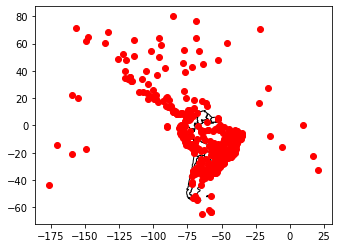

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.continent == 'South America'].plot(color='white', edgecolor='black')

sirgasGDF.plot(ax=ax, color='red')

plt.show()

# Finding nearest neighbors

In [ ]:
xyz=inverseTrans.TransformPoint(receiverLonLat[0],receiverLonLat[1])
#np.sqrt((sirgasGDF[['X (M)']]-xyz[0])**2+(sirgasGDF[['Y (M)']]-xyz[1])**2+(sirgasGDF[['Z (M)']]-xyz[2])**2)
sirgasGDF['distance (KM)']=np.linalg.norm(sirgasGDF[['X (M)', 'Y (M)', 'Z (M)']].values - xyz, axis=1)/1000
sirgasGDF.sort_values(by='distance (KM)')

,NUM,STATION NAME,X (M),Y (M),Z (M),FLAG,geom,distance (KM)
314,668.000,SJRP 41633M001,3885706.910,-4527124.070,-2249399.894,A,POINT (-49.35995 -20.78552),0.536
328,686.000,SPLI 41677M002,3833257.099,-4525414.192,-2340171.405,A,POINT (-49.73370 -21.66520),104.846
325,683.000,SPFE 48082M001,3829575.672,-4601083.312,-2195192.220,A,POINT (-50.22870 -20.26287),107.510
320,677.000,SPAR 41676M001,3789545.396,-4587255.859,-2290619.107,A,POINT (-50.43979 -21.18466),120.668
327,685.000,SPJA 41686M001,3957806.696,-4440069.892,-2296499.619,A,POINT (-48.28670 -21.24107),122.451
...,...,...,...,...,...,...,...,...
110,225.000,FAIR 40408M001,-2281622.008,-1453595.974,5756961.688,W,POINT (-147.49924 64.97800),10562.904
30,50.000,ATW2 49934M002,-2610899.470,-1560592.900,5587416.735,A,POINT (-149.13230 61.59775),10602.473
29,49.000,ASPA 50503S006,-6100260.194,-996502.531,-1567977.175,A,POINT (-170.72244 -14.32609),10613.185
364,786.000,UTQI 49508M002,-1880399.977,-813136.683,6019921.495,A,POINT (-156.61502 71.32275),10743.074


# Stations not beyond maxDistance

In [ ]:
sirgasDF[sirgasDF["distance (KM)"]< (maxDistance/1000.)].sort_values("distance (KM)")

,NUM,STATION NAME,X (M),Y (M),Z (M),FLAG,geom,distance (KM)
314,668.000,SJRP 41633M001,3885706.910,-4527124.070,-2249399.894,A,POINT (-49.35995 -20.78552),0.536
328,686.000,SPLI 41677M002,3833257.099,-4525414.192,-2340171.405,A,POINT (-49.73370 -21.66520),104.846
325,683.000,SPFE 48082M001,3829575.672,-4601083.312,-2195192.220,A,POINT (-50.22870 -20.26287),107.510
320,677.000,SPAR 41676M001,3789545.396,-4587255.859,-2290619.107,A,POINT (-50.43979 -21.18466),120.668
327,685.000,SPJA 41686M001,3957806.696,-4440069.892,-2296499.619,A,POINT (-48.28670 -21.24107),122.451
331,690.000,SPTU 48085M001,3766123.316,-4567433.588,-2367323.583,A,POINT (-50.49237 -21.92912),172.710
103,210.000,EESC 41694M001,3967006.970,-4390247.478,-2375229.683,A,POINT (-47.89918 -22.00495),202.916
326,684.000,SPFR 41693M001,4046871.166,-4398880.631,-2221086.399,A,POINT (-47.38664 -20.51057),207.892
141,307.000,ILHA 41634M001,3735306.350,-4669666.498,-2212269.226,A,POINT (-51.34339 -20.42778),210.509
352,759.000,UBE1 41625M001,4014997.181,-4509022.520,-2052040.411,A,POINT (-48.31697 -18.88953),236.623


In [ ]:
sirgasDF[sirgasDF["STATION NAME"].str.startswith("SJRP")]

,NUM,STATION NAME,X (M),Y (M),Z (M),FLAG,geom,distance (KM)
314,668.000,SJRP 41633M001,3885706.910,-4527124.070,-2249399.894,A,POINT (-49.35995 -20.78552),0.536


In [ ]:
sirgasDF[sirgasDF["STATION NAME"].str.startswith("ONRJ")]


,NUM,STATION NAME,X (M),Y (M),Z (M),FLAG,geom,distance (KM)
230,518.000,ONRJ 41635M001,4283638.373,-4026028.948,-2466096.593,A,POINT (-43.22433 -22.89570),675.547
